# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [63]:
from __future__ import absolute_import, division, print_function

In [64]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [65]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\python38\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


**Set up logging**

In [67]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [68]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [69]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [70]:
print("Found books:")
book_filenames

Found books:


['data\\got1.txt',
 'data\\got2.txt',
 'data\\got3.txt',
 'data\\got4.txt',
 'data\\got5.txt']

**Combine the books into one string**

In [71]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\got1.txt'...
Corpus is now 1787941 characters long

Reading 'data\got2.txt'...
Corpus is now 4110003 characters long

Reading 'data\got3.txt'...
Corpus is now 6452402 characters long

Reading 'data\got4.txt'...
Corpus is now 8185413 characters long

Reading 'data\got5.txt'...
Corpus is now 9811978 characters long



**Split the corpus into sentences**

In [72]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [73]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [74]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [75]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [76]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [77]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


## Train Word2Vec

In [78]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 200
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 5

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [79]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [80]:
thrones2vec.build_vocab(sentences)

2020-10-30 17:14:28,553 : INFO : collecting all words and their counts
2020-10-30 17:14:28,554 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-30 17:14:28,583 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2020-10-30 17:14:28,615 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2020-10-30 17:14:28,646 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2020-10-30 17:14:28,676 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2020-10-30 17:14:28,703 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2020-10-30 17:14:28,733 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2020-10-30 17:14:28,771 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2020-10-30 17:14:28,800 : INFO : PROGRESS: at 

In [81]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


**Start training, this might take a minute or two...**

In [63]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=20)

2020-10-23 13:17:04,801 : INFO : training model with 8 workers on 17277 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2020-10-23 13:17:05,824 : INFO : EPOCH 1 - PROGRESS: at 41.44% examples, 555622 words/s, in_qsize 15, out_qsize 0
2020-10-23 13:17:06,830 : INFO : EPOCH 1 - PROGRESS: at 86.30% examples, 592268 words/s, in_qsize 16, out_qsize 1
2020-10-23 13:17:07,079 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-10-23 13:17:07,083 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-10-23 13:17:07,087 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-10-23 13:17:07,091 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-10-23 13:17:07,097 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-23 13:17:07,105 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-23 13:17:07,128 : INFO : worker thread finished; awaiting finish of 

2020-10-23 13:17:27,432 : INFO : EPOCH 8 - PROGRESS: at 95.00% examples, 435249 words/s, in_qsize 11, out_qsize 0
2020-10-23 13:17:27,490 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-10-23 13:17:27,495 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-10-23 13:17:27,518 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-10-23 13:17:27,524 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-10-23 13:17:27,530 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-23 13:17:27,543 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-23 13:17:27,576 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-23 13:17:27,591 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-23 13:17:27,592 : INFO : EPOCH - 8 : training on 1818103 raw words (1404433 effective words) took 3.2s, 437734 effective words/s
2020-10-23 13:17:28,6

2020-10-23 13:17:50,927 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-23 13:17:50,928 : INFO : EPOCH - 14 : training on 1818103 raw words (1404042 effective words) took 3.7s, 380085 effective words/s
2020-10-23 13:17:51,944 : INFO : EPOCH 15 - PROGRESS: at 23.78% examples, 329480 words/s, in_qsize 15, out_qsize 0
2020-10-23 13:17:52,951 : INFO : EPOCH 15 - PROGRESS: at 51.93% examples, 356747 words/s, in_qsize 14, out_qsize 1
2020-10-23 13:17:53,974 : INFO : EPOCH 15 - PROGRESS: at 80.84% examples, 368748 words/s, in_qsize 15, out_qsize 0
2020-10-23 13:17:54,553 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-10-23 13:17:54,588 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-10-23 13:17:54,592 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-10-23 13:17:54,606 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-10-23 13:17:54,615 : INFO : worker thread finished; await

(28087845, 36362060)

**Save to file, can be useful later**

In [38]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [64]:
thrones2vec.save(os.path.join("trained", "thrones2vec2.w2v"))

2020-10-23 13:18:24,725 : INFO : saving Word2Vec object under trained/thrones2vec2.w2v, separately None
2020-10-23 13:18:24,727 : INFO : not storing attribute vectors_norm
2020-10-23 13:18:24,728 : INFO : not storing attribute cum_table
2020-10-23 13:18:25,046 : INFO : saved trained/thrones2vec2.w2v


## Explore the trained model.

In [82]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec2.w2v"))

2020-10-30 17:14:33,976 : INFO : loading Word2Vec object from trained\thrones2vec2.w2v
2020-10-30 17:14:34,178 : INFO : loading wv recursively from trained\thrones2vec2.w2v.wv.* with mmap=None
2020-10-30 17:14:34,179 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 17:14:34,180 : INFO : loading vocabulary recursively from trained\thrones2vec2.w2v.vocabulary.* with mmap=None
2020-10-30 17:14:34,181 : INFO : loading trainables recursively from trained\thrones2vec2.w2v.trainables.* with mmap=None
2020-10-30 17:14:34,182 : INFO : setting ignored attribute cum_table to None
2020-10-30 17:14:34,182 : INFO : loaded trained\thrones2vec2.w2v


### Compress the word vectors into 2D space and plot them

In [83]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [84]:
all_word_vectors_matrix = thrones2vec.wv.syn0

<ipython-input-84-d3183187c341>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  all_word_vectors_matrix = thrones2vec.wv.syn0


**Train t-SNE, this could take a minute or two...**

In [68]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [46]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [47]:
points.head(10)

,word,x,y
0,This,-17.506039,24.132391
1,edition,-51.418938,-15.217595
2,the,17.492561,-27.146095
3,complete,-2.015012,-3.954489
4,of,17.478731,-27.132561
5,original,-2.280639,-4.184187
6,hardcover,-51.100986,-15.108896
7,ONE,-39.536282,-18.832239
8,A,-0.954972,-2.103668
9,OF,-46.662045,-23.549465


In [48]:
sns.set_context("poster")

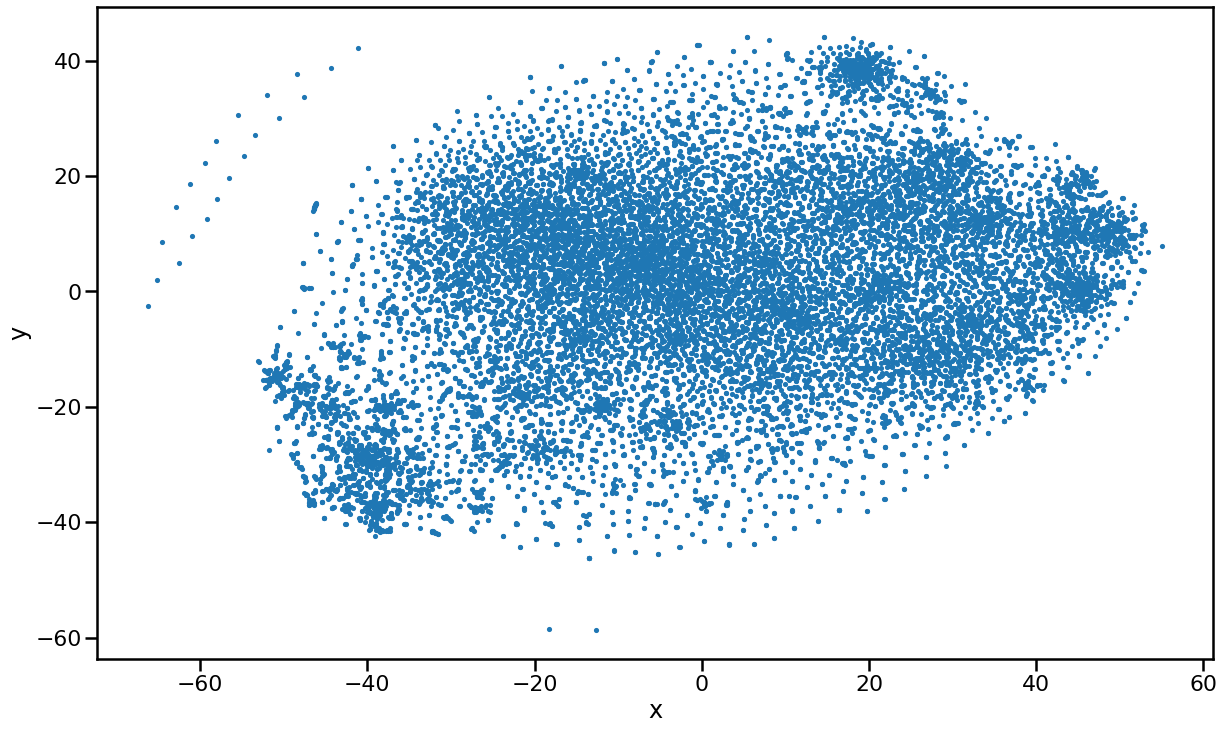

In [49]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [52]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

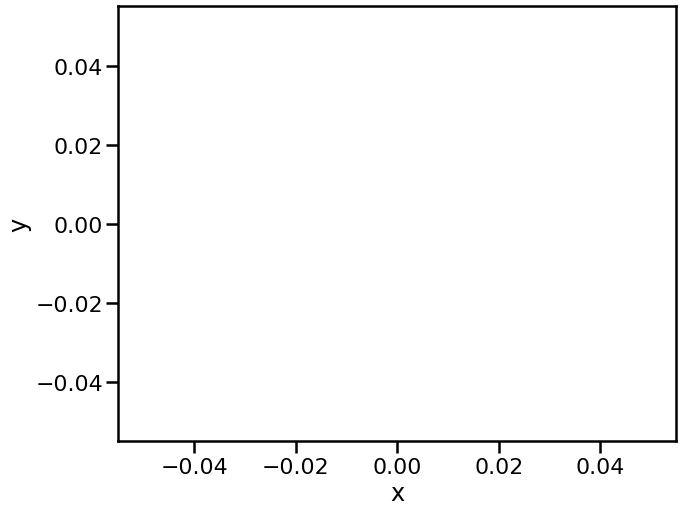

In [53]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

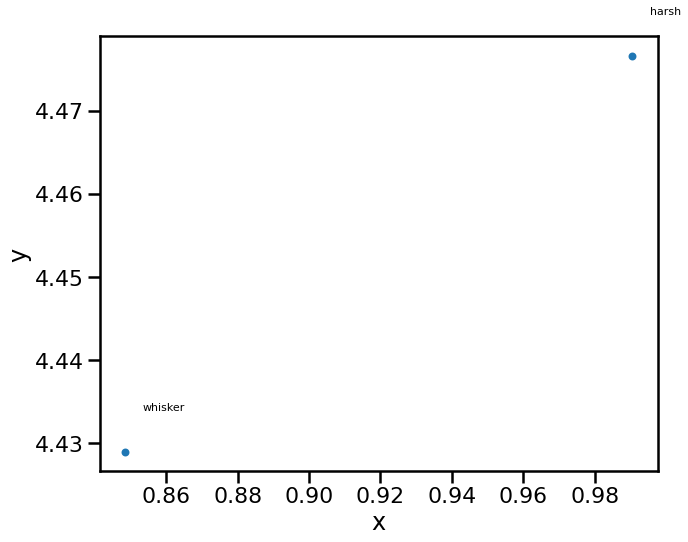

In [54]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [55]:
thrones2vec.most_similar("Stark")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-10-23 13:14:26,684 : INFO : precomputing L2-norms of word weight vectors


[('Eddard', 0.6278519630432129),
 ('executed', 0.46499180793762207),
 ('Edrick', 0.4570099115371704),
 ('Snowbeard', 0.44750261306762695),
 ('fishwife', 0.43596887588500977),
 ('absently', 0.42928290367126465),
 ('divulge', 0.42519763112068176),
 ('Knelt', 0.42425549030303955),
 ('Winterfell', 0.42383724451065063),
 ('Harlon', 0.4227962791919708)]

In [56]:
thrones2vec.most_similar("Aerys")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('II', 0.5442414283752441),
 ('Jaehaerys', 0.46791911125183105),
 ('Defiance', 0.46287500858306885),
 ('Mad', 0.44824790954589844),
 ('V', 0.44407474994659424),
 ('Arrogant', 0.43781718611717224),
 ('Conciliator', 0.43069419264793396),
 ('Beggar', 0.43010413646698),
 ('appointment', 0.4247305989265442),
 ('Argilac', 0.4219787120819092)]

In [57]:
thrones2vec.most_similar("direwolf")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wolf', 0.5064713954925537),
 ('SHAGGYDOG', 0.4983903169631958),
 ('WIND', 0.45752573013305664),
 ('GHOST', 0.4568237364292145),
 ('muzzle', 0.43967050313949585),
 ('Ghost', 0.41620373725891113),
 ('RICKON', 0.41439205408096313),
 ('Asleep', 0.41378137469291687),
 ('EDDISON', 0.41243839263916016),
 ('pup', 0.4052620828151703)]

**Linear relationships between word pairs**

In [58]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [38]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as Tyrion is related to wine
Arya is related to Nymeria, as Dany is related to dragons


u'Dany'

In [81]:
# Wie ähnlich sind sich Jon und Ygritte?
thrones2vec.wv.similarity('Jon','Ygritte')

0.49345273

In [74]:
# Wie sieht der Vektor aus zu Arryn?
thrones2vec['Arryn']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.1911663 , -0.62644655,  0.3695581 ,  0.89800334, -0.36054695,
       -0.04974138, -0.10397656,  0.0363899 , -0.31027585,  0.15885589,
        0.08080822,  0.5516873 ,  0.30099753, -0.28292343, -0.3665119 ,
        0.10673544, -0.63677686,  0.5378115 , -0.3904058 ,  0.9901878 ,
       -0.25178427, -0.14123748, -0.17479338,  0.41264197,  0.10139627,
       -0.24251   , -0.29193112, -0.63433945, -0.34708872, -0.08457909,
        0.7160349 , -0.14465368, -0.01245082,  0.12424694,  0.5117046 ,
       -0.04160964,  0.30707037,  0.2981565 , -0.44564644,  0.12871683,
       -0.12146568, -0.73746425, -0.8279654 , -0.08648793, -0.33168975,
        0.4315791 ,  0.00836129,  0.26412082, -0.04183806, -0.3128724 ,
       -0.13004525, -0.26429892, -0.32331544, -0.320794  , -0.1240222 ,
       -0.68948615, -0.06554055,  0.70215446, -0.24300966,  0.2287467 ,
        0.2454536 ,  0.16841862, -0.98270196,  0.11637519,  0.49754828,
        0.01014811,  0.13789096, -0.5249557 ,  0.03530001,  0.36

In [75]:
# Welche 7 Wörter sind am ähnlichsten zu Lannister?
thrones2vec.wv.most_similar('Lannister', topn=7)

2020-10-23 13:26:33,222 : INFO : precomputing L2-norms of word weight vectors


[('Jaime', 0.5263116359710693),
 ('Tywin', 0.48266303539276123),
 ('crimson', 0.4678238034248352),
 ('pays', 0.46244561672210693),
 ('combatant', 0.45427417755126953),
 ('Cersei', 0.45364734530448914),
 ('downfall', 0.4526490569114685)]

In [76]:
# Was ergibt: Stark + Winterfell – Dragons?
thrones2vec.most_similar(positive=['Stark', 'Winterfell'], negative=['Dragons'], topn=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('Eddard', 0.5621539354324341)]

In [78]:
# Was passt nicht „Winterfell, Riverrun, Jaime“?
thrones2vec.wv.doesnt_match('Winterfell Riverrun Jaime'.split())

/opt/conda/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'Jaime'

In [80]:
import pyemd

# Wie ähnlich sind sich folgende Sätze:
# Satz1: „Hodor That was all he ever said“
# Satz2: „Hold the door

text1 = 'Hodor That was all he ever said'.lower().split()
text2 = 'Hold the door'.lower().split()
similarity= thrones2vec.wv.wmdistance(text1, text2)
print(similarity)

2020-10-23 13:31:20,384 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-10-23 13:31:20,386 : INFO : built Dictionary(10 unique tokens: ['all', 'ever', 'he', 'hodor', 'said']...) from 2 documents (total 10 corpus positions)


4.459166669096231


2020-10-30 17:19:37,339 : INFO : loading Word2Vec object from trained\thrones2vec2.w2v
2020-10-30 17:19:37,530 : INFO : loading wv recursively from trained\thrones2vec2.w2v.wv.* with mmap=None
2020-10-30 17:19:37,531 : INFO : setting ignored attribute vectors_norm to None
2020-10-30 17:19:37,532 : INFO : loading vocabulary recursively from trained\thrones2vec2.w2v.vocabulary.* with mmap=None
2020-10-30 17:19:37,532 : INFO : loading trainables recursively from trained\thrones2vec2.w2v.trainables.* with mmap=None
2020-10-30 17:19:37,533 : INFO : setting ignored attribute cum_table to None
2020-10-30 17:19:37,534 : INFO : loaded trained\thrones2vec2.w2v
<ipython-input-93-057f97570340>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = np.zeros(shape=(max_count,len(model['dog'])))
<ipython-input-93-057f97570340>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use sel

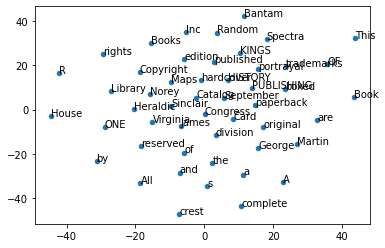

In [93]:
import gensim
from nltk.data import find

word2vec_sample  = os.path.join("trained", "thrones2vec2.w2v")
model = gensim.models.Word2Vec.load(word2vec_sample)

# 2D Model anzeigen
import numpy as np
labels = []
count = 0
max_count = 50
X = np.zeros(shape=(max_count,len(model['dog'])))

for term in model.wv.vocab:
    X[count] = model[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

# Show the scatter plot
import matplotlib.pyplot as plt
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()